<a href="https://colab.research.google.com/github/danielhou13/cogs402longformer/blob/main/src/ConvertSlidingAttentionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [3]:
pip install transformers --quiet

In [4]:
pip install captum --quiet

In [5]:
pip install datasets --quiet

In [6]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
from datasets import load_dataset
cogs402_ds = load_dataset("danielhou13/cogs402dataset")["test"]

Using custom data configuration danielhou13--cogs402dataset-cc784554b797f843
Reusing dataset parquet (/root/.cache/huggingface/datasets/danielhou13___parquet/danielhou13--cogs402dataset-cc784554b797f843/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
from transformers import LongformerForSequenceClassification, LongformerTokenizer, LongformerConfig
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'danielhou13/longformer-finetuned_papers'

# load model
model = LongformerForSequenceClassification.from_pretrained(model_path, num_labels = 2, output_attentions=True)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

In [10]:
def predict(inputs, position_ids=None, attention_mask=None):
    output = model(inputs,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    return output.logits, output.attentions, output.global_attentions

In [11]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [12]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, truncation = True, add_special_tokens=False, max_length = 2046)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_longformer_embeddings(input_ids, ref_input_ids, \
                                          token_type_ids=None, ref_token_type_ids=None, \
                                          position_ids=None, ref_position_ids=None):
    input_embeddings = model.longformer.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.longformer.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    print(input_embeddings.shape)
    return input_embeddings, ref_input_embeddings

In [13]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

In [14]:
testval = 923
text = cogs402_ds['text'][testval]
label = cogs402_ds['labels'][testval]
print(label)

0


In [15]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)

position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [16]:
print(input_ids.squeeze().shape)

torch.Size([2048])


In [17]:
score, attention, global_attention = predict(input_ids, position_ids, attention_mask)

In [18]:
label=torch.tensor(label)
print(label)

tensor(0)


In [19]:
# print(attention[1])
# print(attention[1].sum(dim=0))
# print("non_zero", torch.nonzero(attention[1] - attention[1].sum(dim=0)))
# print(attention[1].sum(dim=0).unsqueeze(0).shape)

# batch_attn = torch.cat([l.sum(dim=0).unsqueeze(0) for l in attention], dim=0).detach().cpu().numpy()
# print(batch_attn.shape)

In [20]:
# shape -> layer x batch x head x seq_len x attention_window
output_attentions_all = torch.stack(attention).cpu()

global_attention_all = torch.stack(global_attention).cpu()

In [21]:
print(output_attentions_all.device)
print(global_attention_all.device)

cpu
cpu


In [22]:
test = output_attentions_all[11][0][11]
global_test = global_attention_all[11][0][11]

print(len(all_tokens))
print(test.shape[0])

print(global_test.squeeze().shape)

def create_head_matrix(output_attentions, global_attentions):
  new_attention_matrix = torch.zeros((output_attentions.shape[0], 
                                      output_attentions.shape[0]))
  for i in range(output_attentions.shape[0]):
    test_non_zeroes = torch.nonzero(output_attentions[i]).squeeze()
    test2 = output_attentions[i][test_non_zeroes[1:]]
    new_attention_matrix_indices = test_non_zeroes[1:]-257 + i
    new_attention_matrix[i][new_attention_matrix_indices] = test2
    new_attention_matrix[i][0] = output_attentions[i][0]
    new_attention_matrix[0] = global_attentions.squeeze()[:output_attentions.shape[0]]
  return new_attention_matrix


def attentions_all_heads(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
      matrix = create_head_matrix(output_attentions[i], global_attentions[i])
      new_matrix.append(matrix)
    return torch.stack(new_matrix)

def all_batches(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
      matrix = attentions_all_heads(output_attentions[i], global_attentions[i])
      new_matrix.append(matrix)
    return torch.stack(new_matrix)

def all_layers(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
      matrix = all_batches(output_attentions[i], global_attentions[i])
      new_matrix.append(matrix)
    return torch.stack(new_matrix)

2048
2048
torch.Size([2048])


In [23]:
new_matrix = create_head_matrix(test, global_test)
# new_matrix2 = attentions_all_heads(output_attentions_all[11][0], 
#                                    global_attention_all[11][0])
# new_matrix3 = all_batches(output_attentions_all[11], 
#                           global_attention_all[11])
new_matrix4 = all_layers(output_attentions_all, 
                         global_attention_all)
print(new_matrix)
# print(new_matrix2.shape)
# print(new_matrix3.shape)
print(new_matrix4.shape)

tensor([[0.0010, 0.0007, 0.0009,  ..., 0.0008, 0.0009, 0.0008],
        [0.0051, 0.0067, 0.0064,  ..., 0.0000, 0.0000, 0.0000],
        [0.0051, 0.0034, 0.0055,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0124, 0.0000, 0.0000,  ..., 0.0287, 0.0284, 0.0228],
        [0.0122, 0.0000, 0.0000,  ..., 0.0248, 0.0239, 0.0209],
        [0.0135, 0.0000, 0.0000,  ..., 0.0200, 0.0233, 0.0209]],
       grad_fn=<CopySlices>)
torch.Size([12, 1, 12, 2048, 2048])


In [24]:
print(new_matrix.shape)

torch.Size([2048, 2048])


In [40]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(30, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(2, 6, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='magma')

        fontdict = {'fontsize': 10}

        # ax.set_xticks(range(len(all_tokens)))
        # ax.set_yticks(range(len(all_tokens)))

        # ax.set_xticklabels(all_tokens, rotation=90)
        # ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()
  
def visualize_token2token_onehead(scores_mat, head_num):
    fig, ax = plt.subplots()
    fig.set_figheight(50)
    fig.set_figwidth(50)
    scores_np = np.array(scores_mat[head_num-1])
    print(scores_np.shape)
    c = ax.imshow(scores_np, cmap='magma')
    fontdict = {'fontsize': 10}
    # ax.set_xticks(range(len(all_tokens)))
    # ax.set_yticks(range(len(all_tokens)))
    # ax.set_xticklabels(all_tokens, rotation=80)
    # ax.set_yticklabels(all_tokens, fontdict=fontdict)

    ax.set_xlabel('{} {}'.format("Head", head_num))

    plt.colorbar(c, fraction=0.046, pad=0.04)
    plt.show()

In [26]:
layer=11

(2048, 2048)


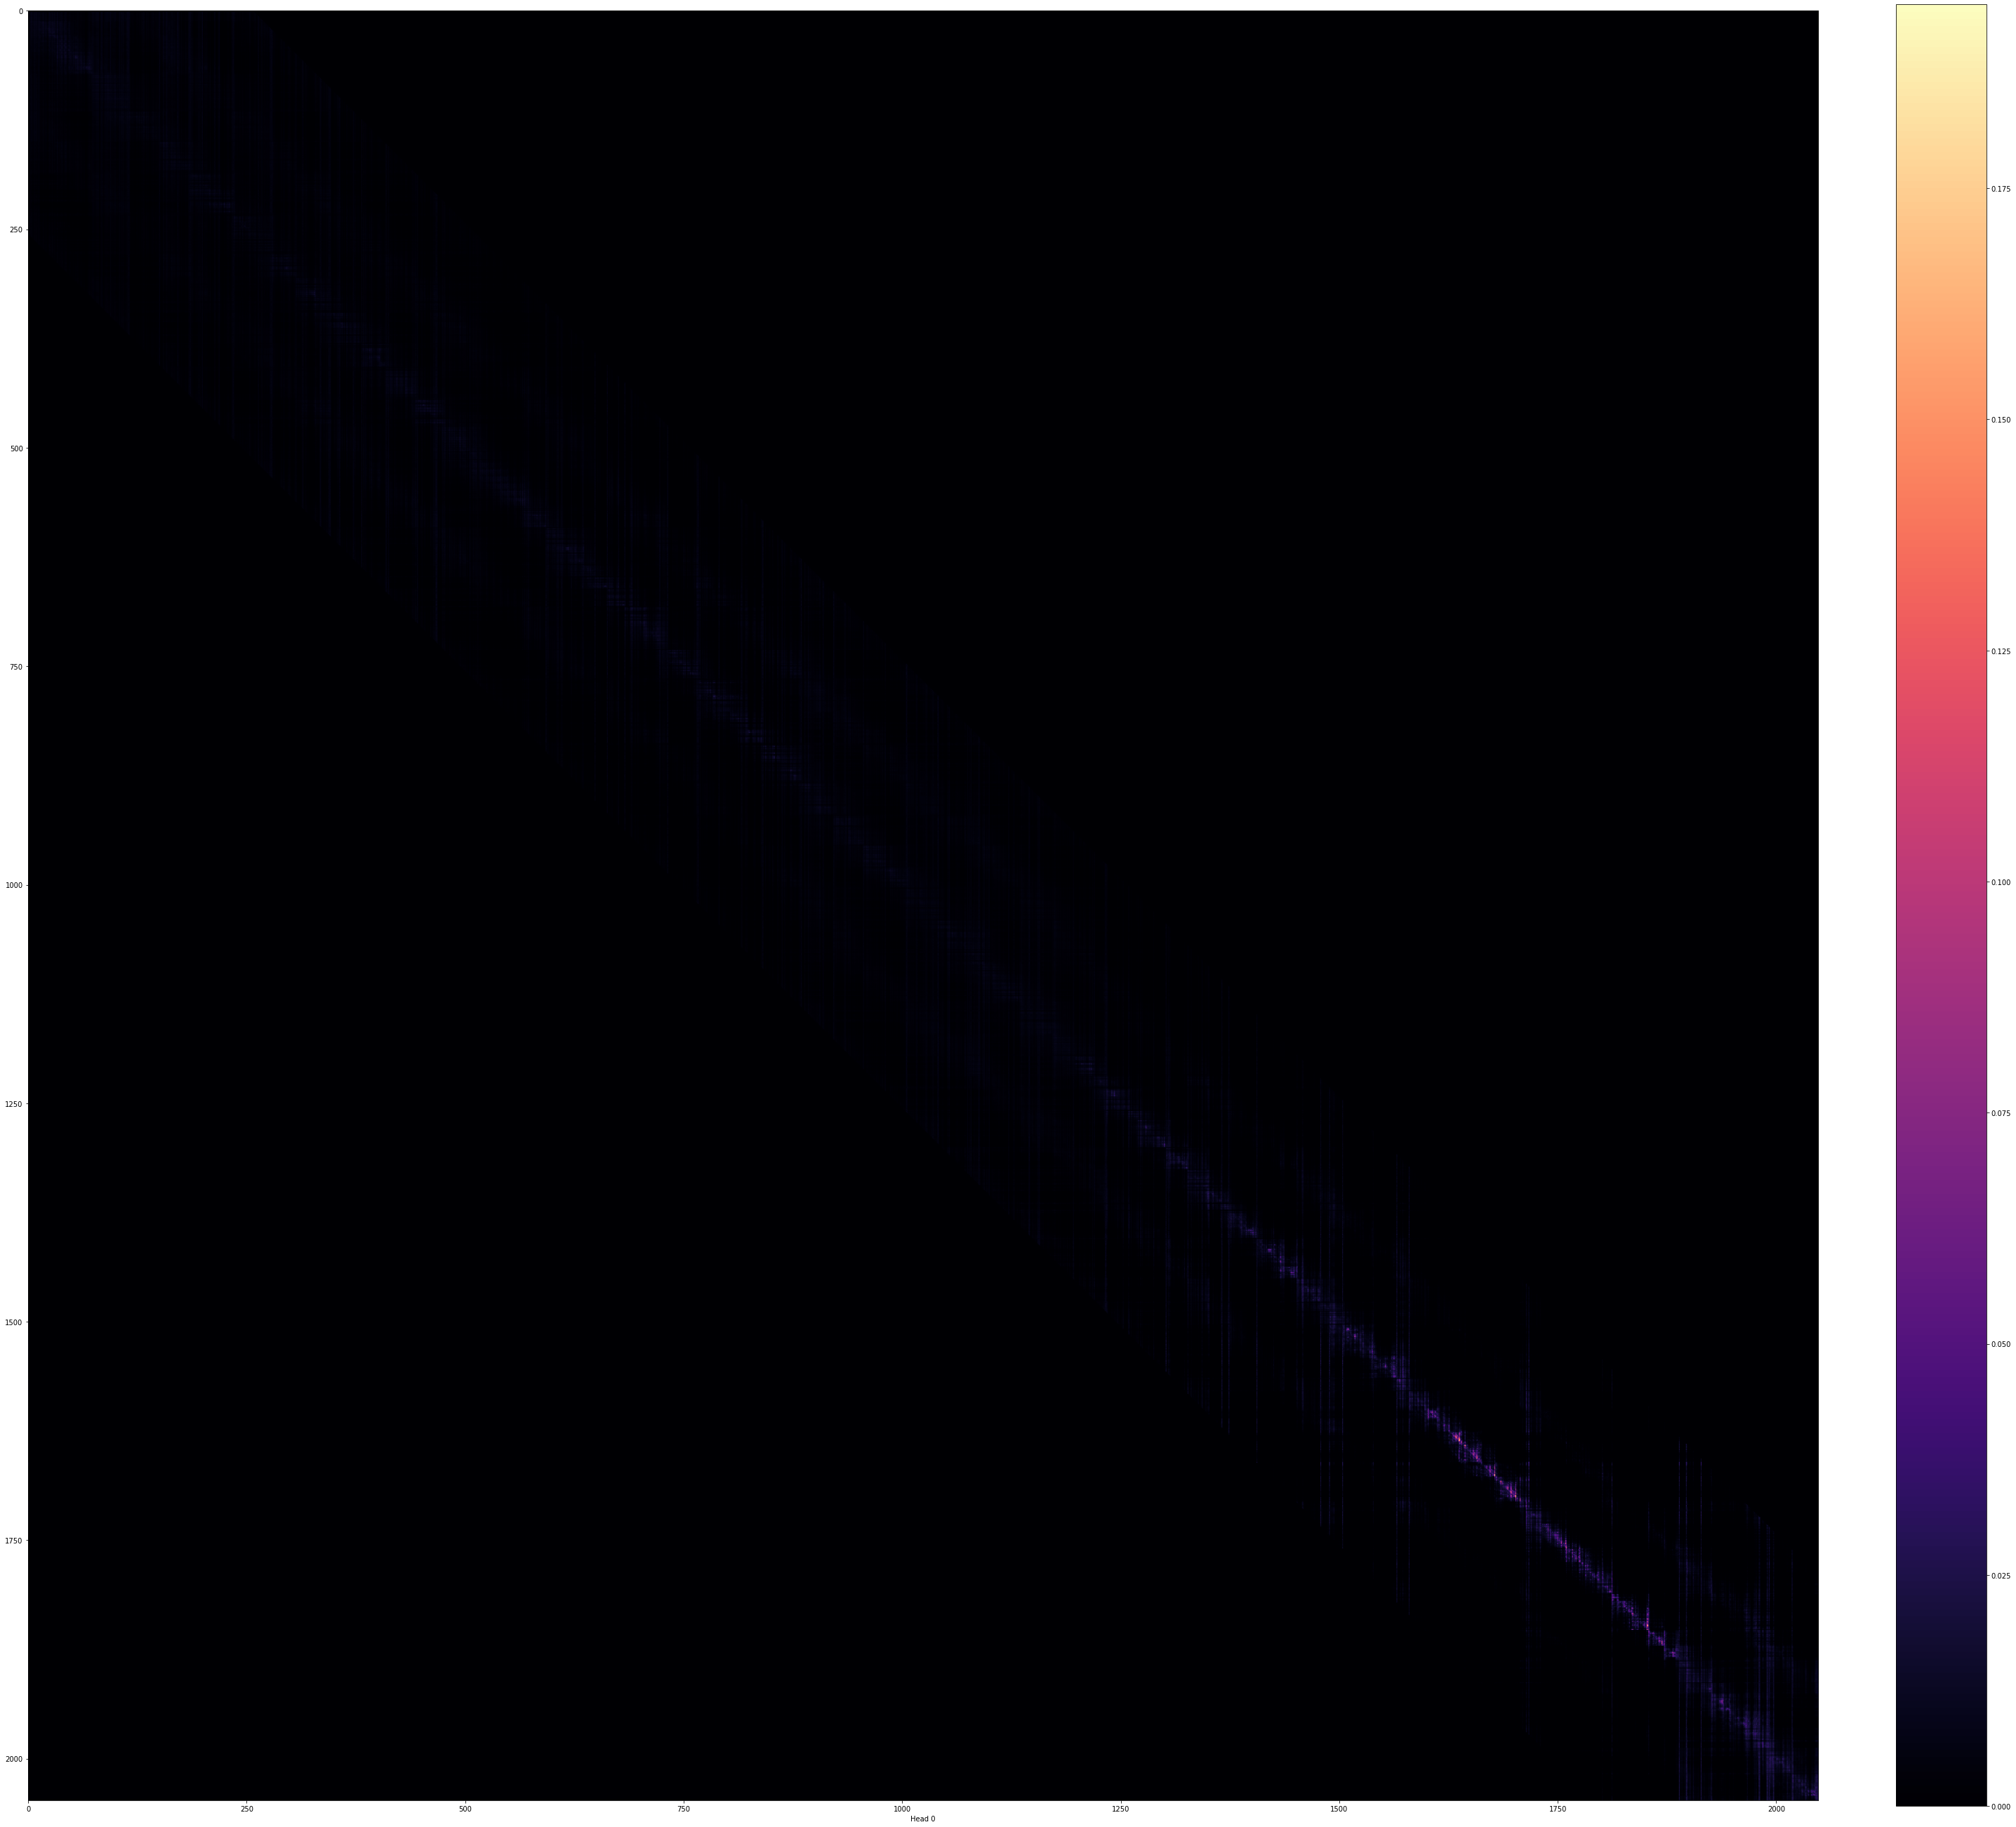

In [36]:
visualize_token2token_onehead(new_matrix4[layer].squeeze().detach().cpu().numpy(), 0)

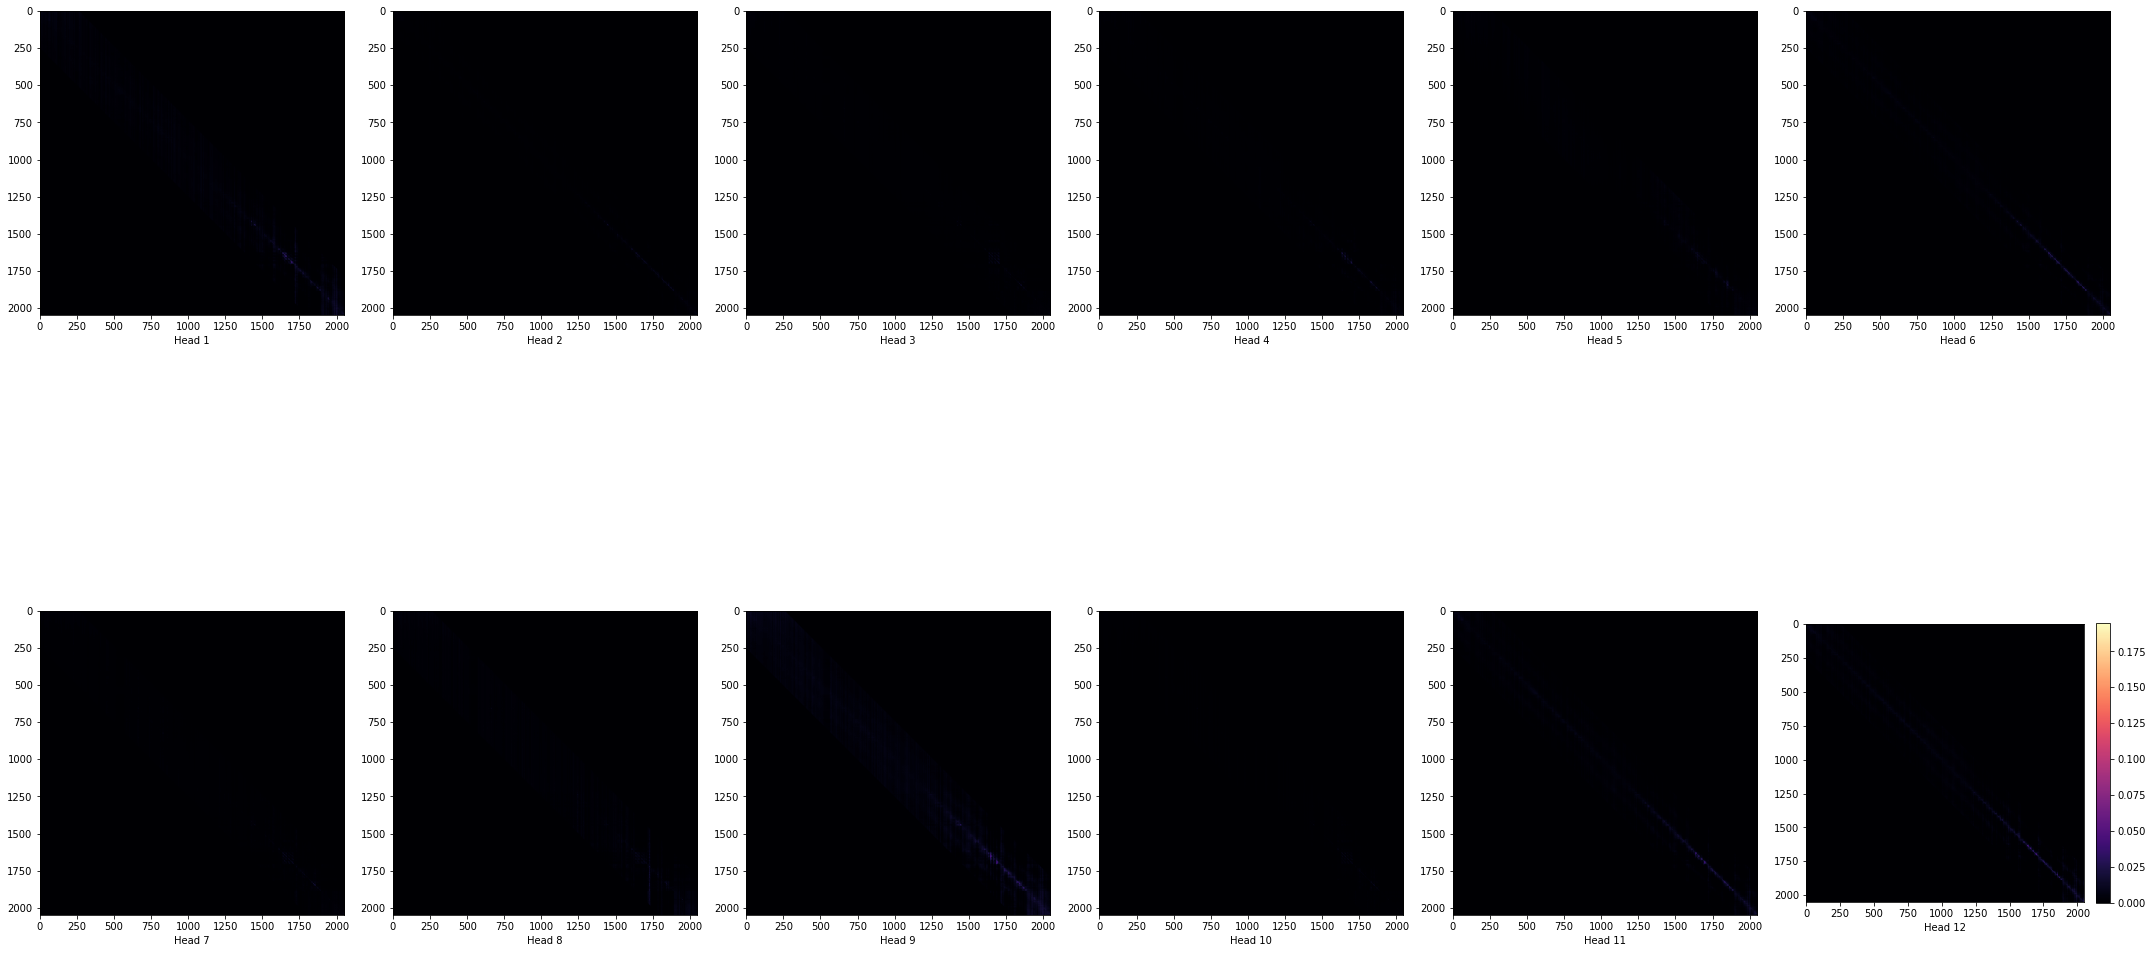

In [41]:
visualize_token2token_scores(new_matrix4[layer].squeeze().detach().cpu().numpy())

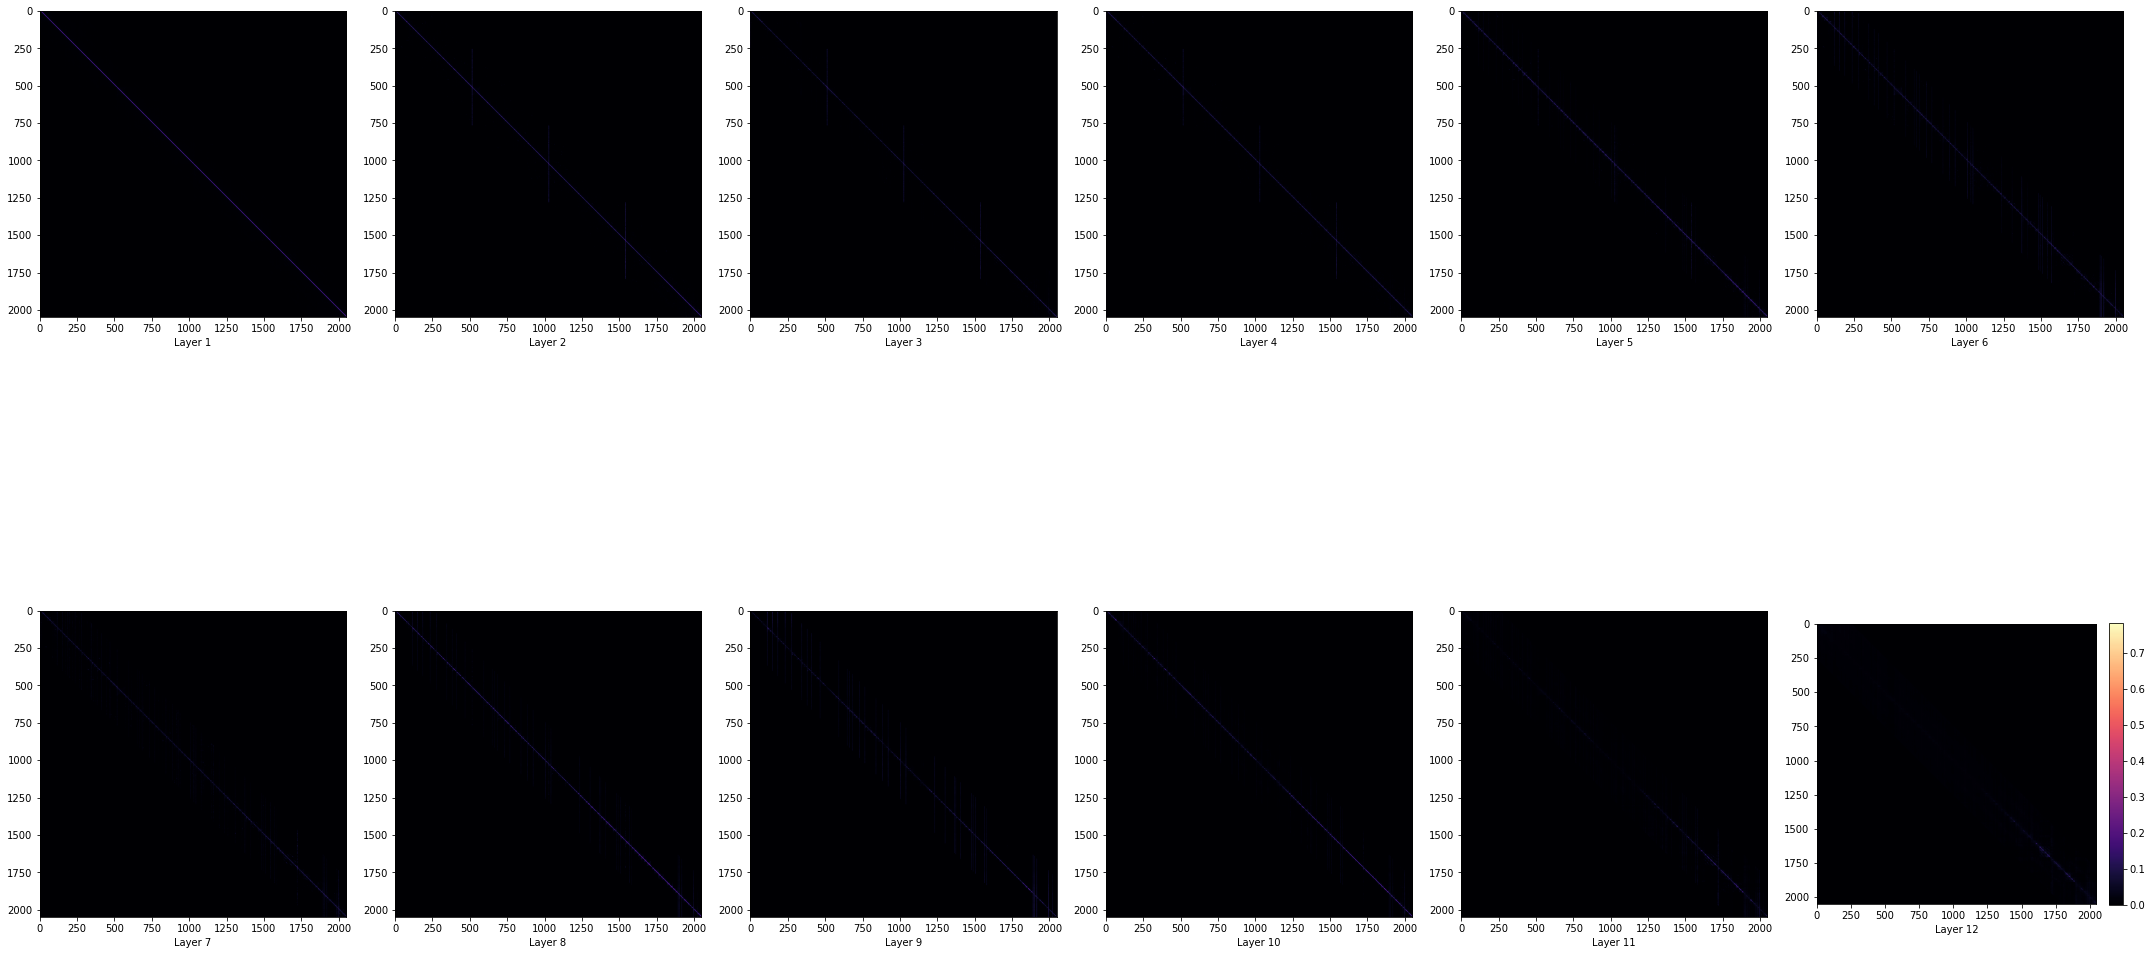

In [42]:
visualize_token2token_scores(norm_fn(new_matrix4, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')